In [ ]:
from google.colab import drive, sheets
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, concatenate, TimeDistributed
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences, TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

In [ ]:
drive.mount('/content/drive', force_remount=True)
file_path = '/content/drive/MyDrive/ML/final_project/data/processed/df_merged.csv'
data = pd.read_csv(file_path)

# Convert 'date' column to datetime and sort by ticker and date (chronological order)
data['date'] = pd.to_datetime(data['date'])
data.sort_values(['ticker', 'date'], inplace=True)
data.reset_index(drop=True, inplace=True)

# Get unique tickers (e.g., NVDA, PG, VOO)
tickers = data['ticker'].unique()

# Dictionaries to store processing objects and data splits per ticker
tokenizers = {}
max_seq_len = {}
scalers = {}
train_sequences = {}
test_sequences = {}

# Define window size and numeric feature names
window_size = 30  # using 30 days as the sequence length
numeric_features = ['close', 'volume', 'open', 'high', 'low']

test_dfs = {}  # Dictionary to store test dataframes
for ticker in tickers:
    # Filter data for the current ticker
    df_ticker = data[data['ticker'] == ticker].reset_index(drop=True)

    # 80/20 chronological split (first 80% for training, later 20% for testing)
    split_index = int(len(df_ticker) * 0.8)
    train_df = df_ticker.iloc[:split_index].reset_index(drop=True)
    test_df = df_ticker.iloc[split_index:].reset_index(drop=True)

    # Ensure headlines (title) are strings and fill any missing values
    train_df['title'] = train_df['title'].fillna('').astype(str)
    test_df['title'] = test_df['title'].fillna('').astype(str)

    test_dfs[ticker] = test_df

    # Tokenize headlines using Keras Tokenizer (fit on training data only)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_df['title'])
    tokenizers[ticker] = tokenizer

    # Convert titles to sequences and then pad them
    train_title_seq = tokenizer.texts_to_sequences(train_df['title'])
    test_title_seq = tokenizer.texts_to_sequences(test_df['title'])

    # Determine the maximum sequence length for this ticker
    max_len = max(max(len(seq) for seq in train_title_seq), max(len(seq) for seq in test_title_seq))
    max_seq_len[ticker] = max_len

    X_train_title_pad = pad_sequences(train_title_seq, maxlen=max_len, padding='post')
    X_test_title_pad = pad_sequences(test_title_seq, maxlen=max_len, padding='post')

    # Scale numeric features with MinMaxScaler (fit only on training data to avoid leakage)
    scaler = MinMaxScaler()
    scaler.fit(train_df[numeric_features])
    scalers[ticker] = scaler

    train_num_scaled = scaler.transform(train_df[numeric_features])
    test_num_scaled = scaler.transform(test_df[numeric_features])

    # Build sliding-window sequences for the training data
    X_num_train, X_text_train, y_train = [], [], []
    for i in range(len(train_num_scaled) - window_size):
        X_num_train.append(train_num_scaled[i : i + window_size])
        X_text_train.append(X_train_title_pad[i : i + window_size])
        # The target is the next day’s 'close' price (first feature)
        y_train.append(train_num_scaled[i + window_size][0])
    X_num_train = np.array(X_num_train)
    X_text_train = np.array(X_text_train)
    y_train = np.array(y_train)

    # Build sliding-window sequences for the testing data
    X_num_test, X_text_test, y_test = [], [], []
    for i in range(len(test_num_scaled) - window_size):
        X_num_test.append(test_num_scaled[i : i + window_size])
        X_text_test.append(X_test_title_pad[i : i + window_size])
        y_test.append(test_num_scaled[i + window_size][0])
    X_num_test = np.array(X_num_test)
    X_text_test = np.array(X_text_test)
    y_test = np.array(y_test)

    train_sequences[ticker] = (X_num_train, X_text_train, y_train)
    test_sequences[ticker] = (X_num_test, X_text_test, y_test)

Mounted at /content/drive


In [ ]:
def build_model(ticker):
    """
    Build the multi-input LSTM model for a given ticker.
    One branch processes the numeric features, and the other processes tokenized headlines.
    """
    seq_length = max_seq_len[ticker]        # maximum headline length for current ticker
    vocab_size = len(tokenizers[ticker].word_index) + 1  # vocabulary size (+1 for reserved index)
    n_num_features = len(numeric_features)  # number of numeric features

    # Numeric input branch
    numeric_input = Input(shape=(window_size, n_num_features), name=f"{ticker}_numeric_input")
    numeric_lstm = LSTM(64, activation='relu')(numeric_input)

    # Text input branch
    text_input = Input(shape=(window_size, seq_length), name=f"{ticker}_text_input")
    # Embed and process each day's headline with an LSTM (applied day-wise using TimeDistributed)
    embedded_text = TimeDistributed(Embedding(input_dim=vocab_size, output_dim=50, input_length=seq_length))(text_input)
    per_day_text_vec = TimeDistributed(LSTM(32, activation='relu'))(embedded_text)
    text_lstm = LSTM(32, activation='relu')(per_day_text_vec)

    # Combine both branches and produce the final prediction
    combined = concatenate([numeric_lstm, text_lstm])
    dense1 = Dense(32, activation='relu')(combined)
    output = Dense(1, activation='linear')(dense1)

    model = Model(inputs=[numeric_input, text_input], outputs=output)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

# Build a dictionary of models (one per ticker)
models = {}
for ticker in tickers:
    models[ticker] = build_model(ticker)
    print(f"\n{ticker} model summary:")
    models[ticker].summary()


NVDA model summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ NVDA_text_input     │ (None, 30, 480)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 30, 480,   │    377,400 │ NVDA_text_input[… │
│ (TimeDistributed)   │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NVDA_numeric_input  │ (None, 30, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 30, 32)    │     10,624 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     17,920 │ NVDA_numeric_inp… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 32)        │      8,320 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96)        │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      3,104 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 417,401 (1.59 MB)

 Trainable params: 417,401 (1.59 MB)

 Non-trainable params: 0 (0.00 B)


PG model summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ PG_text_input       │ (None, 30, 46)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 30, 46,    │     87,300 │ PG_text_input[0]… │
│ (TimeDistributed)   │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PG_numeric_input    │ (None, 30, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 30, 32)    │     10,624 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 64)        │     17,920 │ PG_numeric_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 32)        │      8,320 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 96)        │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      3,104 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 127,301 (497.27 KB)

 Trainable params: 127,301 (497.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Mount the drive and define the model saving directory
drive.mount('/content/drive', force_remount=True)
save_dir = "/content/drive/MyDrive/ML/final_project/results/models_v1"
os.makedirs(save_dir, exist_ok=True)

# Define the path for the loss history JSON file
history_filepath = os.path.join(save_dir, "loss_histories.json")

# If the JSON file exists, load its content; otherwise, start with an empty dictionary
if os.path.exists(history_filepath):
    with open(history_filepath, "r") as f:
        loss_histories = json.load(f)
    print(f"Loaded existing loss histories from {history_filepath}")
else:
    loss_histories = {}

# Loop over the tickers and train or load models accordingly.
for ticker in tickers:
    model_filepath = os.path.join(save_dir, f"{ticker}_model.keras")

    # Check if model file already exists
    if os.path.exists(model_filepath):
        print(f"\nModel for {ticker} already exists at {model_filepath}. Loading model and skipping training.")
        models[ticker] = load_model(model_filepath)
        # Even if we skip training, ensure that the ticker is present in loss_histories (or leave it as is)
        if ticker not in loss_histories:
            loss_histories[ticker] = {}  # You might want to leave it empty or indicate "not trained"
        continue  # Skip training for this ticker

    print(f"\n--- Training model for {ticker} ---")
    X_num_train, X_text_train, y_train = train_sequences[ticker]
    X_num_test, X_text_test, y_test = test_sequences[ticker]
    model = models[ticker]

    # Train the model
    history = model.fit(
        [X_num_train, X_text_train], y_train,
        validation_data=([X_num_test, X_text_test], y_test),
        epochs=20,
        batch_size=32,
        verbose=2
    )

    # Update the loss_histories dictionary for this ticker with the new history
    loss_histories[ticker] = history.history

    # Save the model in native Keras format
    model.save(model_filepath)
    print(f"Saved model for {ticker} to {model_filepath}")

# After processing all tickers, write the updated loss_histories back to the JSON file
with open(history_filepath, "w") as f:
    json.dump(loss_histories, f)

Mounted at /content/drive
Loaded existing loss histories from /content/drive/MyDrive/ML/final_project/modelsv1/loss_histories.json

--- Training model for NVDA ---
Epoch 1/20
91/91 - 63s - 688ms/step - loss: 1.7477e-04 - mae: 0.0079 - val_loss: 0.5566 - val_mae: 0.5675
Epoch 2/20
91/91 - 84s - 923ms/step - loss: 1.6941e-04 - mae: 0.0077 - val_loss: 0.3466 - val_mae: 0.4421
Epoch 3/20
91/91 - 82s - 898ms/step - loss: 1.6577e-04 - mae: 0.0077 - val_loss: 0.3689 - val_mae: 0.4616
Epoch 4/20
91/91 - 83s - 908ms/step - loss: 1.7469e-04 - mae: 0.0076 - val_loss: 0.2708 - val_mae: 0.3918
Epoch 5/20
91/91 - 82s - 897ms/step - loss: 1.7979e-04 - mae: 0.0083 - val_loss: 0.1928 - val_mae: 0.3317
Epoch 6/20
91/91 - 78s - 859ms/step - loss: 1.6279e-04 - mae: 0.0076 - val_loss: 0.2191 - val_mae: 0.3683
Epoch 7/20
91/91 - 83s - 911ms/step - loss: 1.5257e-04 - mae: 0.0073 - val_loss: 0.1422 - val_mae: 0.2958
Epoch 8/20
91/91 - 83s - 907ms/step - loss: 1.4874e-04 - mae: 0.0070 - val_loss: 0.0919 - val_

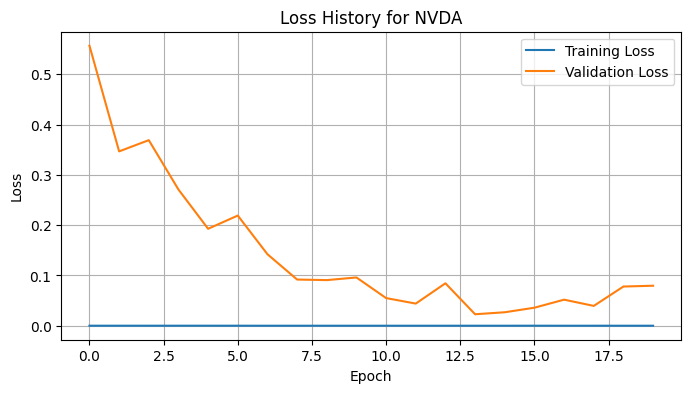

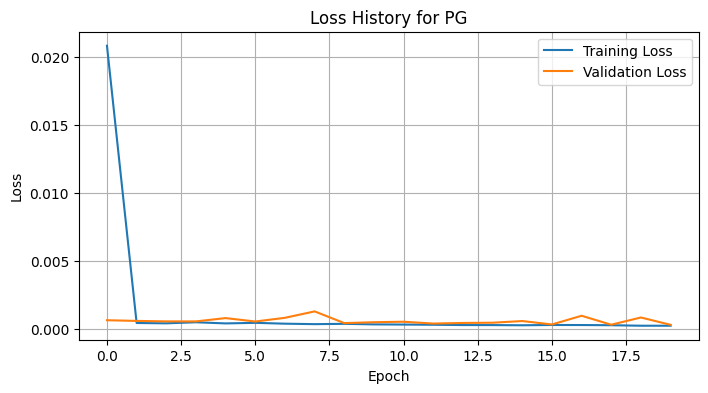

In [ ]:
history_filepath = "/content/drive/MyDrive/ML/final_project/results/models_v1/loss_histories.json"
with open(history_filepath, "r") as f:
    loss_histories = json.load(f)

# Assume that tickers is a list like: ["NVDA", "PG", "VOO"]
for ticker in tickers:
    ticker_history = loss_histories.get(ticker, None)
    if ticker_history is None:
        print(f"No history found for {ticker}")
        continue

    plt.figure(figsize=(8, 4))
    plt.plot(ticker_history["loss"], label="Training Loss")
    plt.plot(ticker_history["val_loss"], label="Validation Loss")
    plt.title(f"Loss History for {ticker}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 978ms/step


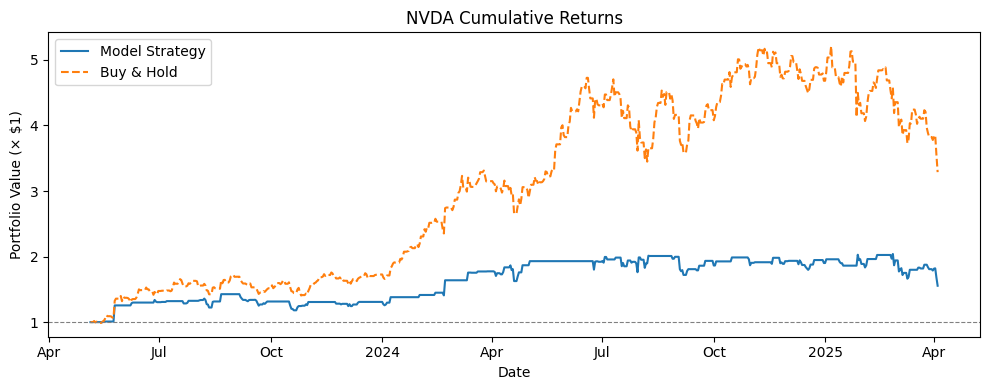

model:1.5548498741726977
hold:3.2883542538354313
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step


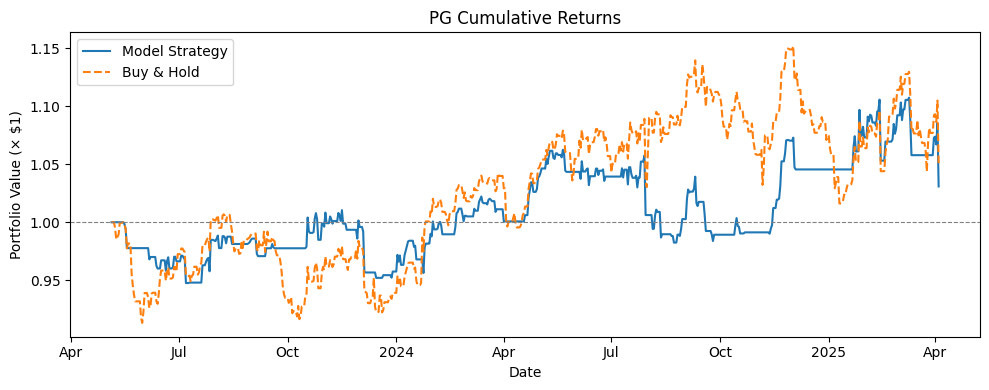

model:1.0308484342500621
hold:1.0494776645516886


In [ ]:
for ticker in tickers:
    # 1) Get test data
    Xn_t, Xt_t, yt_scaled = test_sequences[ticker]
    dates = pd.to_datetime(test_dfs[ticker]["date"]).iloc[window_size:].reset_index(drop=True)

    # 2) Predict and inverse‑scale via dummy trick
    y_pred_scaled = models[ticker].predict([Xn_t, Xt_t]).flatten()
    dummy = np.zeros((len(y_pred_scaled), len(numeric_features)))
    dummy[:, 0] = y_pred_scaled
    y_pred = scalers[ticker].inverse_transform(dummy)[:, 0]

    dummy_true = np.zeros((len(yt_scaled), len(numeric_features)))
    dummy_true[:, 0] = yt_scaled
    y_true = scalers[ticker].inverse_transform(dummy_true)[:, 0]

    # 3) Build daily returns for both strategies
    #  – Model strategy: long when pred↑, else flat
    signal = np.zeros_like(y_pred, dtype=int)
    signal[1:] = (y_pred[1:] > y_pred[:-1]).astype(int)
    pct_model = np.zeros_like(y_true)
    pct_model[1:] = np.where(signal[1:]==1, (y_true[1:]/y_true[:-1]) - 1, 0.0)
    cum_model = np.cumprod(1 + pct_model)

    #  – Buy & Hold: always long
    pct_hold = np.zeros_like(y_true)
    pct_hold[1:] = (y_true[1:]/y_true[:-1]) - 1
    cum_hold = np.cumprod(1 + pct_hold)

    # 4) Plot both on same axes
    plt.figure(figsize=(10, 4))
    plt.plot(dates, cum_model, label="Model Strategy")
    plt.plot(dates, cum_hold,  linestyle="--", label="Buy & Hold")
    plt.axhline(1.0, color="gray", lw=0.8, ls="--")
    plt.title(f"{ticker} Cumulative Returns")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value (× $1)")
    plt.legend()
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
    plt.tight_layout()
    plt.show()

    print(f'model:{cum_model[-1]}')
    print(f'hold:{cum_hold[-1]}')